# Logistic regression

### Outline
1. Logistic regression for binary classification
    - Recall the perceptron
    - Softening the perceptron
    - Sigmoid function
    - Logistic regression model
    - Interpretation using log odds
    - Log loss
2. Logistic regression for multiclass classification
    - Recall soft classification
    - Softmax
    - Multiclass logistic regression
    - Cross-entropy loss
    

## Logistic regression for binary classification

### Setup
As usual, we are given a labelled dataset for binary classification with the following form:
- There are $m$ instances in the dataset. 
- There are $n$ features $X_i$, each corresponding to a column vector $\mathbf{x}_i \in \mathbb{R}^m$. 
- There is a single binary target $Y$ which takes the value $0$ or $1$ for each instance. The target is represented by a column vector $\mathbf{y} \in \{0,1\}^m$.
We write $\vec{x}_i$ for the $i$-th row of the feature matrix $\mathbf{X}$.

### Recall the perceptron
Recall that the perceptron is a linear classifier which picks out a single hyperplane in the feature space $\mathbb{R}^n$ to separate the two classes, i.e. for all instances $\vec{x}$ lying on one side of the hyperplane, the perceptron predicts $0$, and for all instances on the other side, it predicts $1$.

The parameters of the perceptron consist of a weight vector $\vec{w} \in \mathbb{R}^n$ and bias $b \in \mathbb{R}$. The hyperplane dividing the two classes is defined by the equation $\vec{w} \cdot \vec{x} + b = 0$. In the other words, the set of points lying on the hyperplane is:
\begin{equation*}
    \{ \vec{x} \in \mathbb{R}^n \mid \vec{w} \cdot \vec{x} + b = 0 \}.
\end{equation*}
(We saw last time that this is an affine space that is parallel to the subspace of vectors orthogonal to $\vec{w}$.) 

Now, the perceptron $P_{\vec{w},b}$ is defined as:
\begin{equation*}
    P_{\vec{w},b}(\vec{x}) = H(\vec{w} \cdot \vec{x} + b) = 
    \begin{cases}
        1 & \text{if } \; (\vec{w} \cdot \vec{x} + b) > 0, \\
        0 & \text{if } \; (\vec{w} \cdot \vec{x} + b) < 0.
    \end{cases}
\end{equation*}
Recall that the parameters $(\vec{w},b)$ are learned via the perceptron algorithm, which starts by initializing arbitrary weights, and then iteratively updates them by looking at the misclassified instances. The algorithm terminates when all the instances are correctly classified, or after a fixed number of iterations (determined by the user at the beginning). 

### Softening the perceptron
The perceptron is hard classifier, i.e. it only outputs $0$ or $1$. We turn now to the problem of converting it into a soft classifier, i.e. one the outputs a pair of real numbers $(p_0,p_1)$, where $p_0$ is the probability that the instance belongs to class $0$, and $p_1$ is the probability that it belongs to class $1$. Since $p_0 + p_1 = 1$, we can equivalently output just $p_1$.

That is, we want to construct a function $L_{\vec{w},b} : \mathbb{R}^n \to [0,1]$ such that $L_{\vec{w},b}(\vec{x})$ is the probability that the instance $\vec{x}$ belongs to class $1$.

To accomplish this, we can leave the linear part of the function alone and try to modify the thresholding part (the Heaviside function) to something that is not so jumpy. To set this up, let $z$ denote the output of the linear part, i.e.
\begin{equation*}
    z = \vec{w} \cdot \vec{x} + b.
\end{equation*}
We want to replace the Heaviside function $H(z)$ with a function $L(z)$ that is continuous and smooth, and that satisfies the following properties:
1. $L(z) \in (0,1)$ for all $z \in \mathbb{R}$ (i.e. $L$ is a probability).
2. $L(z)$ is a monotonically increasing function of $z$ (i.e. $L$ squishes the entire $z$-line into the interval $(0,1)$, and it does it in such a way that if $z_1 < z_2$ then $L(z_1) < L(z_2)$).
3. $L(z)$ is smooth (i.e. differentiable) everywhere. (This is not strictly necessary, but it will be useful later on, when we will want to use gradient descent to learn the parameters.)
4. $L(0) = 0.5$ (i.e. the predicted probability of being in class $1$ is $0.5$ for points $\vec{x}$ lying on the dividing hyperplane $z = 0$; in some sense, this is saying that the hyperplane is the "equilibrium" point between the two classes, with maximum uncertainty).

### Sigmoid function(s)
There is a parametric class of functions that satisfy all of the above properties; they are called **sigmoid functions**:
\begin{equation*}
    \sigma(z) = \frac{1}{1 + e^{-Tz}},
\end{equation*}
where $T > 0$ is a parameter that controls the steepness of the function. The most common choice is $T = 1$, in which case we write $\sigma(z) = \frac{1}{1 + e^{-z}}$ and call it the **logistic function**.

In the plot below, we compare the Heaviside and sigmoid functions. Note that all four properties above are preserved as we vary the slider for $T$. The only thing that changes is how fast the sigmoid function goes from $0$ to $1$ as $z$ increases from $-\infty$ to $+\infty$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def create_plots(T=1.0):
    # Create figure with two subplots side by side using plt.subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Create x values
    x = np.linspace(-10, 10, 1000)
    
    # First subplot: Heaviside function
    ax1.set_ylim(-0.2, 1.2)
    ax1.set_xlim(-10, 10)
    
    # Heaviside function
    heaviside = np.zeros_like(x)
    heaviside[x >= 0] = 1.0
    
    # Plot Heaviside in two colors
    ax1.plot(x[x<0], heaviside[x<0], 'steelblue', linewidth=2)
    ax1.plot(x[x>=0], heaviside[x>=0], 'indianred', linewidth=2)
    
    # Horizontal and vertical lines
    ax1.axhline(y=0.5, color='black', linestyle='--', alpha=0.7)
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Set labels and grid style
    ax1.set_title('Heaviside Step Function', fontsize=14)
    ax1.set_xlabel('z', fontsize=12)
    ax1.set_ylabel('H(z)', fontsize=12)
    ax1.grid(True, color='white', linestyle='-', linewidth=0.7, alpha=0.3)
    ax1.set_facecolor('#f8f8f8')
    
    # Second subplot: Sigmoid function with color map
    ax2.set_ylim(-0.2, 1.2)
    ax2.set_xlim(-10, 10)
    
    # Sigmoid function
    sigmoid = 1 / (1 + np.exp(-T * x))
    
    # Create a scatter plot with colors based on y-value
    cmap = plt.get_cmap('coolwarm')
    scatter = ax2.scatter(x[::20], sigmoid[::20], c=sigmoid[::20], cmap=cmap, 
                         s=30, alpha=0.8, vmin=0, vmax=1)
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Sigmoid Value', rotation=270, labelpad=20)
    
    # Plot the sigmoid line
    ax2.plot(x, sigmoid, 'k-', alpha=0.5, linewidth=1.5)
    
    # Horizontal and vertical lines
    ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.7)
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Set labels and grid style
    ax2.set_title(f'Sigmoid Function: 1/(1 + e^(-T·z)) with T = {T:.2f}', fontsize=14)
    ax2.set_xlabel('z', fontsize=12)
    ax2.set_ylabel('σ(z)', fontsize=12)
    ax2.grid(True, color='white', linestyle='-', linewidth=0.7, alpha=0.3)
    ax2.set_facecolor('#f8f8f8')
    
    plt.tight_layout()
    plt.show()

# Create an interactive widget
interact(
    create_plots,
    T=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='T:')
)

interactive(children=(FloatSlider(value=1.0, description='T:', max=5.0, min=0.1), Output()), _dom_classes=('wi…

<function __main__.create_plots(T=1.0)>

Let's compare the outputs of a Perceptron and Logistic Regression model for a binary classification task. Namely, we try to predict whether `target` is `1` or `0` to represent whether the particular county will vote in favor of the Democratic party or Republican part (for simplicity, we omit any third option). We use only the features `edu_low` and `marital_single`. To start, let's read in the data and display the dictionary to see what's in the dataset.

In [78]:
import pandas as pd
import json

# read in presidential election dataset
df_train = pd.read_csv('../data/classification/presidential_election_binary/train.csv')
df_test = pd.read_csv('../data/classification/presidential_election_binary/test.csv')

# read in the data_description json file as a dictionary
with open('../data/classification/presidential_election_binary/data_description.json') as f:
    data_description = json.load(f)
data_description

{'fips': 'Federal Information Processing Standard (FIPS) county code',
 'year': 'Election year',
 'area_sqmi': 'County area in square miles',
 'pop_density': 'Population density (people per square mile)',
 'income_median': 'Median household income',
 'income_percapita': 'Per capita income',
 'income_poverty': 'Population below poverty line',
 'income_10': 'Population with income below $10,000',
 'income_10-15': 'Population with income between $10,000-$15,000',
 'income_15-25': 'Population with income between $15,000-$25,000',
 'income_25': 'Population with income above $25,000',
 'pop_male': 'Proportion of male population',
 'pop_female': 'Proportion of female population',
 'hispanic': 'Proportion of Hispanic population',
 'labor_total': 'Proportion of working-age population',
 'labor_armed': 'Proportion in armed forces',
 'labor_employed': 'Proportion employed',
 'labor_unemployed': 'Proportion unemployed',
 'native_yes': 'Proportion of native-born citizens',
 'native_no': 'Proportion

Next, let's fit the model to the data with our chosen features. We will use the `LogisticRegression` class from `sklearn.linear_model`. The `fit` method will train the model on the data, and the `predict_proba` method will give us the predicted probabilities for each class (as opposed to the `predict` method, which outputs the predicted class labels).

In [79]:
# features = ['edu_low','edu_high','marital_single','marital_sepdiv', 'native_no','race_wht_total','race_blk_total','area_sqmi','pop_density','income_poverty','hispanic']

features = ['edu_low','marital_single']

# fit a logistic regression model with edu_low and marital_single as predictors
from sklearn.linear_model import LogisticRegression

X_train = df_train[features]
y_train = df_train['target']
X_test = df_test[features]
y_test = df_test['target']

model = LogisticRegression()
model.fit(X_train, y_train)

#display the coefficients
print('Coefficients:')
print('Intercept:', round(model.intercept_[0], 3))
print('edu_low:', round(model.coef_[0][0], 3))
print('marital_single:', round(model.coef_[0][1], 3))

# display the accuracies on the train and test sets
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print()
print('Train accuracy:', round(train_accuracy, 3))
print('Test accuracy:', round(test_accuracy, 3))

Coefficients:
Intercept: -5.252
edu_low: -2.4
marital_single: 17.729

Train accuracy: 0.826
Test accuracy: 0.821


Let $x_1$ and $x_2$ represent the features `edu_low` and `marital_single`, respectively. Then our logistic regression model is given by the parameters
\begin{equation*}
    \vec{w},b = (w_1,w_2,b) = (-2.4,17.729,-5.252).
\end{equation*}
In other words, the first linear part of the model is defined by
\begin{equation*}
    z = \vec{w} \cdot \vec{x} + b = -2.4x_1 + 17.729x_2 - 5.252.
\end{equation*}
The output of the logistic regression model (which uses the logistic function) is then given by
\begin{align*}
    L_{\vec{w},b}(\vec{x}) &= \frac{1}{1 + \exp(-z)} \\
    &= \frac{1}{1 + \exp{(2.4x_1 - 17.729x_2 + 5.252)}}.
\end{align*}
That is, given an instance $\vec{x} = (x_1,x_2)$, the predicted probability that the instance belongs to class $1$ (according to the model) is given by the above formula. 

NOTE: We can convert the logistic regression model back to the perceptron model by declaring the threshold to be $0.5$. That is, we can say that the perceptron predicts $1$ if $L_{\vec{w},b}(\vec{x}) >= 0.5$, and $0$ otherwise. By construction, these conditions are equivalent to $z >= 0$ and $z < 0$, respectively.

So, in this case, the perceptron model would therefore be given by
\begin{equation*}
    P_{\vec{w},b}(\vec{x}) = H(z) = 
    \begin{cases}
        1 & \text{if } \; -2.4x_1 + 17.729x_2 - 5.252 \geqslant 0, \\
        0 & \text{if } \; -2.4x_1 + 17.729x_2 - 5.252 < 0.
    \end{cases}
\end{equation*}

/opt/anaconda3/envs/math392/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


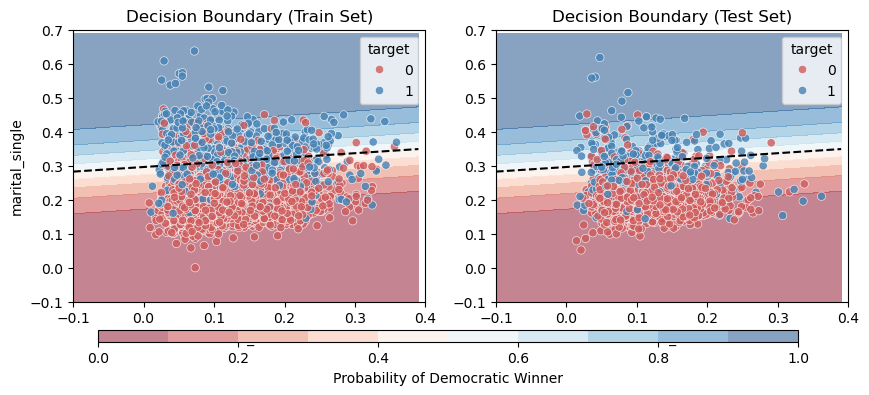

In [81]:
import seaborn as sns

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Define color palette for visualization - blue for Democratic (1), red for Republican (0)
palette = {1: 'steelblue', 0: 'indianred'}

# Define the grid boundaries for visualization
x_min, x_max = -0.1, 0.4  # Range for edu_low
y_min, y_max = -0.1, 0.7  # Range for marital_single

# Create a mesh grid for calculating probabilities across the feature space
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Get probability predictions for each point in the grid
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]  
Z = Z.reshape(xx.shape)

# Plot training set
contour1 = ax1.contourf(xx, yy, Z, alpha=0.5, levels=np.linspace(0, 1, 11), cmap='RdBu')
ax1.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')
sns.scatterplot(x='edu_low', y='marital_single', data=df_train, 
                alpha=0.8, hue='target', palette=palette, ax=ax1)
ax1.set_xlabel('edu_low')
ax1.set_ylabel('marital_single')
ax1.set_title('Decision Boundary (Train Set)')

# Plot test set
contour2 = ax2.contourf(xx, yy, Z, alpha=0.5, levels=np.linspace(0, 1, 11), cmap='RdBu')
ax2.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')
sns.scatterplot(x='edu_low', y='marital_single', data=df_test, 
                alpha=0.8, hue='target', palette=palette, ax=ax2)
ax2.set_xlabel('edu_low')
ax2.set_ylabel('')  # Remove y-axis label from second subplot
ax2.set_title('Decision Boundary (Test Set)')

# Set identical axis limits for both plots
for ax in [ax1, ax2]:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Add a horizontal colorbar at the bottom
plt.subplots_adjust(bottom=0.2)  # Make room for the colorbar
cax = fig.add_axes([0.15, 0.1, 0.7, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(contour1, cax=cax, orientation='horizontal', label='Probability of Democratic Winner')

plt.show()

In the above plots, we see the following:
- The axes represent our chosen features `edu_low` and `marital_single` (i.e. $x_1$ and $x_2$), so our plot is visualizing the data points living in the feature space spanned by $x_1$ and $x_2$ axis.
- The dots are colored blue for `1` and red for `0` (their true labels).
- The black dashed line represents the decision boundary of our logistic regression model; it consists of all points $\vec{x} = (x_1,x_2)$ such that
\begin{equation*}
    z = -2.4x_1 + 17.729x_2 - 5.252 = 0.
\end{equation*}
Equivalently, it is the set of points $\vec{x}$ such that $L_{\vec{w},b}(\vec{x}) = 0.5$.
- The color gradient in the background represents the predicted probabilities of the logistic regression model. Note that if we take any line parallel to the decision boundary, then the value of $z$ remains constant along the line, and so does the predicted probability $L_{\vec{w},b}(\vec{x})$.
- In general, given a point $\vec{x}$, we can interpret $z$ (more or less) as the orthogonal distance from $\vec{x}$ to the decision boundary. The further away $\vec{x}$ is from the decision boundary, the more certain the model is about its prediction, and as $z$ goes from $-\infty$ to $+\infty$, the predicted probability of being in class $1$ goes from $0$ to $1$.

**Warning**: The intuition behind the logistic regression model is that we should become more confident in our predictions the further away we are from the decision boundary. This is consistent with the kind of picture in which the cloud of red and blue dots are more or less separated, but have some overlap near the decision boundary. 

In practice, however, this may not always be the most logical way to model the situation.

For instance, in our current dataset, we in fact already have a way to measure the "true" probability of voting blue or red, namely, we can interpret the columns `dem` and `repub` (which represent the fraction of votes in favor of either party) as the true probabilities!

In the plot below, we use the true probabilities to color the points, and the background still represents the predicted probabilities. If our predicted probabilities were accuracte, then we should be seeing that the color gradients of the points should more or less match those of the background, but this is not the case!

/opt/anaconda3/envs/math392/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/var/folders/8h/w7q1fjwd5kn8xvqty5sp3h7r0000gn/T/ipykernel_34724/231210609.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


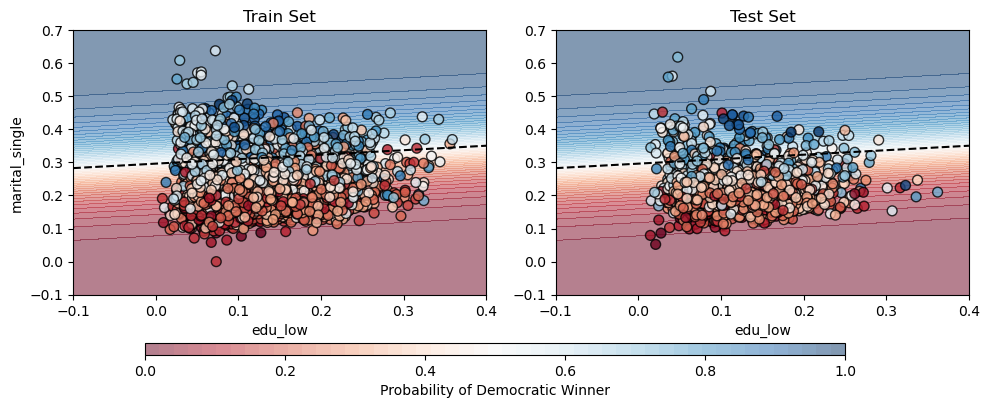

In [88]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Create meshgrid for both plots
x_min, x_max = -0.1, 0.4  # Range for edu_low
y_min, y_max = -0.1, 0.7  # Range for marital_single

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict_proba(grid_points)[:, 1]
Z = Z.reshape(xx.shape)

# Plot training set
contour1 = ax1.contourf(xx, yy, Z, alpha=0.5, levels=np.linspace(0, 1, 50), cmap='RdBu')
ax1.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')
scatter1 = ax1.scatter(X_train['edu_low'], X_train['marital_single'], 
                      c=df_train['dem'], cmap='RdBu', 
                      s=50, edgecolor='k', alpha=0.8)
ax1.set_xlabel('edu_low')
ax1.set_ylabel('marital_single')
ax1.set_title('Train Set')

# Plot test set
contour2 = ax2.contourf(xx, yy, Z, alpha=0.5, levels=np.linspace(0, 1, 50), cmap='RdBu')
ax2.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')
scatter2 = ax2.scatter(X_test['edu_low'], X_test['marital_single'], 
                      c=df_test['dem'], cmap='RdBu', 
                      s=50, edgecolor='k', alpha=0.8)
ax2.set_xlabel('edu_low')
ax2.set_title('Test Set')

# Set identical axis limits for both plots
for ax in [ax1, ax2]:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Add a horizontal colorbar at the bottom
plt.subplots_adjust(bottom=0.2)  # Make room for the colorbar
cax = fig.add_axes([0.15, 0.1, 0.7, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(contour1, cax=cax, orientation='horizontal', 
                   ticks=np.arange(0, 1.2, 0.2), label='Probability of Democratic Winner')

plt.tight_layout()
# add space for the colorbar
plt.subplots_adjust(bottom=0.25)
plt.show()


### Interpretation using log odds
We can interpret the logistic regression model in terms of **log odds**. Recall that the odds of an event $A$ is defined as
\begin{equation*}
    \text{odds}(A) = \frac{\Pr(A)}{1 - \Pr(A)}.
\end{equation*}
The log odds are then defined as
\begin{equation*}
    \text{log odds}(A) = \log(\text{odds}(A)) = \log\left(\frac{\Pr(A)}{1 - \Pr(A)}\right).
\end{equation*}
Now, in our case, the output of the logistic regression model is given by
\begin{equation*}
    p_1 = \Pr(Y=1) =  \frac{1}{1 + \exp(-z)}.
\end{equation*}
Solving for $z$, we get
\begin{equation*}
    z = \log\left(\frac{p_1}{1 - p_1}\right) = \log\left(\frac{\Pr(Y=1)}{\Pr(Y=0)}\right).
\end{equation*}
Thus, we can interpret the logistic regression model as a *linear regression model*, in which the target is not the probability of being in class $1$, but rather the log odds of being in class $1$:
\begin{equation*}
    z = \vec{w} \cdot \vec{x} + b = \log\left(\frac{\Pr(Y=1)}{\Pr(Y=0)}\right).
\end{equation*}

NOTE: It might be useful to keep in mind the predicted probability is conditioned on the features, i.e. $p_1 = p(Y=1 \mid X_1 = x_1, X_2 = x_2)$, which can more succintly be written as $p_1 = p(1\mid \vec{x})$. So, in this form, we have
\begin{equation*}
    z = \log\left(\frac{p(1\mid \vec{x})}{p(0\mid \vec{x})}\right).
\end{equation*}

In [52]:
def log_odds(x):
    return np.log(x / (1 - x))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_loss(p_true, p_pred):
    # compute vector of sample entropies
    sample_entropies = -p_true * np.log(sigmoid(p_pred)) - (1 - p_true) * np.log(1 - sigmoid(p_pred))
    return np.mean(sample_entropies)

In [55]:
# true probability of voting democrat (if you voted democrat or republican)
p_train_true = df_train['dem']
p_test_true = df_test['dem']

# target = log-odds of democratic vote share
z_train_true = log_odds(p_train_true)
z_test_true = log_odds(p_test_true)

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# named llo_model for "linear log odds model"
llo_model = LinearRegression()

# fit the linreg model to the log odds of democratic vote share
llo_model.fit(X_train, z_train_true)

# get vectors of predicted log odds
z_train_pred = llo_model.predict(X_train)
z_test_pred = llo_model.predict(X_test)

# convert into predicted probabilities of voting democract
p_train_pred = sigmoid(z_train_pred)
p_test_pred = sigmoid(z_test_pred)

y_train_pred = p_train_pred >= 0.5
y_test_pred = p_test_pred >= 0.5

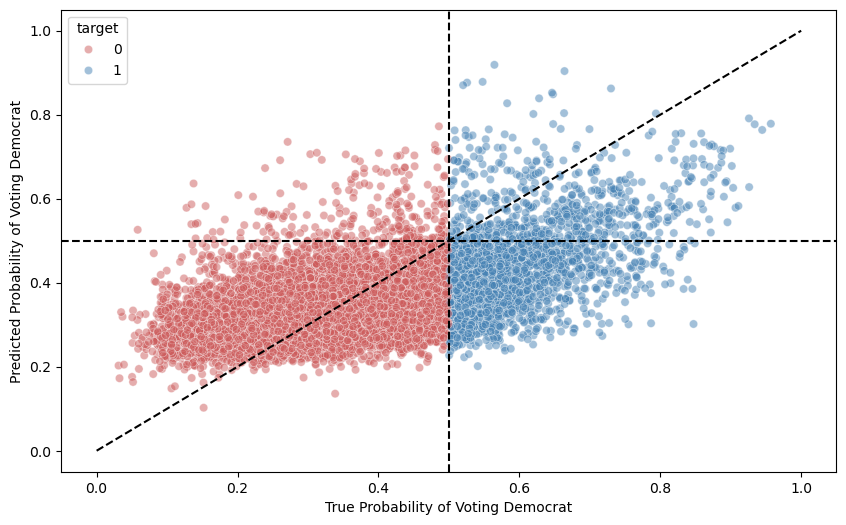

In [42]:
# plot the predicted probabilities vs the true probabilities
plt.figure(figsize=(10, 6))
sns.scatterplot(x= dem_train_true, 
                y= dem_train_pred, 
                alpha=0.5, 
                hue=df_train['target'], 
                palette=palette)
# vertical and horizontal lines at 0.5
plt.axhline(y=0.5, color='black', linestyle='--')
plt.axvline(x=0.5, color='black', linestyle='--')
# diagonal line
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('True Probability of Voting Democrat')
plt.ylabel('Predicted Probability of Voting Democrat')
plt.show()

In [43]:
# get model coefficients
# print the coefficients
print('Intercept:', llo_model.intercept_)
print('edu_low coefficient:', llo_model.coef_[0])
print('marital_single coefficient:', llo_model.coef_[1])

Intercept: -0.5882635714808829
edu_low coefficient: -0.027346348108166958
marital_single coefficient: 0.41433680068225215


### Softening the Perceptron
The perceptron is a simple and elegant algorithm, but it has some limitations. The main limitation is that if the data is not **linearly separable** (i.e. there is no hyperplane separating the two classes perfectly), then the algorithm will not converge to solution (instead, it will continue until the number of iterations is reached, or the accuracy stops improving with further epochs). 

Note also that the perceptron is a hard classifier, since it outputs only $0$ or $1$. 

It is natural then to try to soften the perceptron into a soft classifier: the output should be a float between $0$ and $1$, with larger values indicating higher probability of being in class $1$, and smaller values indicating higher probability of being in class $0$. Quite intuitively/logically, the output should be exactly $0.5$ when the input is on the hyperplane, indicating that the classifier is uncertain about the class of the input along the hyperplane.

In summary, we want to replace the Heaviside function $H$ with a function $\sigma$ that satisfies the following properties (you should note that we will be applying this with $z = \mathbf{w}^T\mathbf{x} + b$):
- $\sigma(z) \in [0,1]$ for all $z \in \mathbb{R}$.
- $\sigma(z) \to 0$ as $z \to -\infty$.
- $\sigma(z) \to 1$ as $z \to \infty$.
- $\sigma(0) = 0.5$.

The function that satisfies these properties is the **logistic function**:
\begin{equation*}
    \sigma(z) = \frac{1}{1 + e^{-z}}.
\end{equation*}
This function is also called the **sigmoid function**. It is a smooth, continuous function that maps any real number to the interval $[0,1]$. It is also differentiable, which makes it useful for optimization algorithms like gradient descent.